<a href="https://colab.research.google.com/github/Biscuitkru/CS5284_Project/blob/main/CS5284_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS5284 Project - CPL Optimisation on Campaign Graphs

## Problem formulation and task type

We study cost-per-lead (CPL) optimisation for paid advertising campaigns.  
Each row in the **“Raw – By device platform”** sheet corresponds to a
campaign configuration at platform × device-platform granularity, with
features such as Platform, Device platform, Objective, headline, spend,
impressions, reach, clicks and leads.

We define:

- **Node**: one campaign configuration (one row in the cleaned dataset).
- **Node features**: engineered tabular features (original fields plus
  ratios such as CTR, LeadRate, SpendPerImpr, ConvRate, time features,
  and headline features).
- **Targets**:
  - continuous CPL (cost-per-lead),
  - a binary label *low-CPL* indicating whether a campaign is in the
    low-CPL regime.

Our goals are:

1. **Segmentation** – find feature segments (clusters of nodes) with
   small within-cluster CPL dispersion so that each segment represents a
   stable CPL pattern.
2. **Prediction** – train a model that can flag future campaigns as
   likely *low-CPL* before launch.

We treat this as a **node-level prediction and segmentation problem on a
k-NN campaign graph**: each node is a campaign, and edges connect
campaigns that are close in feature space. Graph-based models will be
used later on this k-NN graph, and all non-graph baselines operate on
the same node-level features.


In [4]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    !pip install -q transformers
    # mount google drive
    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import itertools
import re
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.linear_model import LogisticRegression

In [3]:
if 'google.colab' in sys.modules:
    # Configs - Google Drive
    data_path = "/content/drive/MyDrive/CS Masters/CS5284/Big-Data-Analysis-Master.xlsx" # Change this to google drive file
    sheets_for_comparison = ["Raw - By device platform", "Raw - By Age Gender"]
else:
    # Configs - Local
    data_path = "data/input/Big-Data-Analysis-Master.xlsx"
    sheets_for_comparison = ["Raw - By device platform", "Raw - By Age Gender"]

# Modeling controls
test_size = 0.2
seed = 777
min_label_count = 50
np.random.seed(seed)


In [5]:
raw_df = pd.read_excel(data_path, sheet_name=sheets_for_comparison[0])

In [6]:
print("Raw Dataset Info:")
display(raw_df.describe())
with pd.option_context('display.max_columns', 999):
  print("NaN Counts:")
  display(pd.DataFrame(raw_df.isna().sum()).T) # Transpose so that the results are displayed as a row instead of a long column - Just a visual thing.

Raw Dataset Info:


,Campaign ID,Ad set ID,Ad ID,Amount spent,"CPM (cost per 1,000 impressions)",Reach,Impressions,Clicks (all),Leads,Cost per Lead,Meta leads,Local Language,Event,Exclusivity,Rental,Returns,Discounts,Frequency
count,9.748000e+03,9.748000e+03,9.748000e+03,9707.000000,9707.000000,9717.000000,9748.000000,6147.000000,1995.000000,1995.000000,1994.000000,1504.000000,7753.000000,3730.000000,1258.000000,1322.000000,906.000000,9717.000000
mean,9.870300e+16,9.976067e+16,1.001561e+17,67.729795,87.294686,1332.129670,2433.045958,36.779730,3.034085,85.642074,3.032598,0.457447,0.894750,0.781233,0.351351,0.382753,0.099338,1.348687
std,4.012533e+16,3.940175e+16,3.912055e+16,170.255334,453.896412,5128.060809,10516.935740,125.291756,4.009372,79.525915,4.006322,0.498352,0.306895,0.413465,0.477582,0.486243,0.299280,0.366534
min,2.385300e+16,2.385300e+16,2.385301e+16,0.009982,0.087637,1.000000,1.000000,1.000000,1.000000,0.152887,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,1.202015e+17,1.202017e+17,1.202020e+17,2.021496,29.762545,31.000000,36.000000,2.000000,1.000000,34.360000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.121951
50%,1.202113e+17,1.202113e+17,1.202114e+17,13.638393,48.564815,176.000000,219.500000,7.000000,1.000000,64.301469,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.260870
75%,1.202160e+17,1.202160e+17,1.202160e+17,59.863725,78.508722,789.000000,1073.000000,25.000000,3.000000,112.034886,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.465767
max,1.202196e+17,1.202199e+17,1.202199e+17,2995.957520,35730.000000,345151.000000,625812.000000,6647.000000,56.000000,1319.640057,56.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.750000


NaN Counts:


,Campaign ID,Ad set ID,Included custom audiences,Excluded custom audiences,Custom Audience Defined,Exclusion Defined,Ad ID,Campaign-Adset-Ad,Ads,Month,Device platform,Platform,Currency,Amount spent,"CPM (cost per 1,000 impressions)",Reach,Impressions,Clicks (all),Leads,Cost per Lead,Meta leads,Objective,headline,Local Language,Event,Exclusivity,Rental,Returns,Discounts,Frequency,Reporting starts,Reporting ends
0,0,0,7891,2942,0,0,0,0,0,0,0,0,0,41,41,31,0,3601,7753,7753,7754,0,816,8244,1995,6018,8490,8426,8842,31,0,0


## Data Preprocessing

In [7]:
platform_df = raw_df.copy()
# age_gender_df = pd.read_excel(data_path, sheet_name=sheets_for_comparison[1])

In [8]:
def clean_platform_data(df):
  """
  For 'Raw - By device platform' sheet
  - Drops all missing CPL entries
  - Removes rows with 'unknown' platform or device platform.
  - Removes rows with missing 'Frequency'.
  - Fills missing values in object and numeric columns.
  - Converts 'Amount spent', 'CPM', and 'Cost per Lead' from MYR to SGD.
  - Renames 'CPM (cost per 1,000 impressions)' to 'CPM' and 'Clicks (all)' to 'Clicks'.
  """
  df = df.copy()

  # Drop all missing CPL lines
  df = df.dropna(subset=['Cost per Lead'])

  # normalize strings
  for c in ["Platform","Device platform","Currency","Objective","headline","Local Language","Event"]:
      if c in df.columns:
          df[c] = df[c].astype(str).str.strip()

  # remove unknowns
  df = df[df['Platform'] != 'unknown']
  df = df[df['Device platform'] != 'unknown']
  df = df[df['Frequency'].notna()]

  # If na, likely means None
  obj_col = ['Included custom audiences', 'Excluded custom audiences', 'headline']
  for col in obj_col:
    df[col] = df[col].fillna('None')

  num_col = ['Meta leads', 'Cost per Lead', 'Leads', 'Clicks (all)', 'Reach', 'CPM (cost per 1,000 impressions)', 'Amount spent']
  for col in num_col:
    df[col] = df[col].fillna(0)

  for c in ["Reporting starts","Reporting ends"]:
      if c in df.columns:
          df[c] = pd.to_datetime(df[c], errors="coerce")

  # If currency myr, spent/3.2
  mask = df["Currency"].str.upper() == "MYR"
  currency_cols = ['Amount spent', 'CPM (cost per 1,000 impressions)', 'Cost per Lead']
  for col in currency_cols:
      df.loc[mask, col] = df.loc[mask, col].astype(float) / 3.2
  df.loc[mask, "Currency"] = "SGD"

  df.rename(columns={'CPM (cost per 1,000 impressions)': 'CPM', 'Clicks (all)': 'Clicks', 'Cost per Lead': 'CPL'}, inplace=True)

  return df.reset_index(drop=True)

In [9]:
platform_df = clean_platform_data(platform_df)

In [10]:
display(platform_df.columns)
platform_df.head()

display(platform_df.describe())
with pd.option_context('display.max_columns', 999):
  print("NaN Counts:")
  display(pd.DataFrame(platform_df.isna().sum()).T) # Transpose so that the results are displayed as a row instead of a long column - Just a visual thing.

Index(['Campaign ID', 'Ad set ID', 'Included custom audiences',
       'Excluded custom audiences', 'Custom Audience Defined',
       'Exclusion Defined', 'Ad ID', 'Campaign-Adset-Ad', 'Ads', 'Month',
       'Device platform', 'Platform', 'Currency', 'Amount spent', 'CPM',
       'Reach', 'Impressions', 'Clicks', 'Leads', 'CPL', 'Meta leads',
       'Objective', 'headline', 'Local Language', 'Event', 'Exclusivity',
       'Rental', 'Returns', 'Discounts', 'Frequency', 'Reporting starts',
       'Reporting ends'],
      dtype='object')

,Campaign ID,Ad set ID,Ad ID,Amount spent,CPM,Reach,Impressions,Clicks,Leads,CPL,Meta leads,Exclusivity,Rental,Returns,Discounts,Frequency,Reporting starts,Reporting ends
count,1.995000e+03,1.995000e+03,1.995000e+03,1995.000000,1995.000000,1995.000000,1995.000000,1995.000000,1995.000000,1995.000000,1995.000000,604.000000,103.000000,107.000000,47.000000,1995.000000,1995,1995
mean,9.644870e+16,9.702835e+16,9.770453e+16,167.393104,52.541653,3003.478697,5074.627569,62.006516,3.034085,63.175530,3.031078,0.960265,0.766990,0.775701,0.489362,1.549701,2023-03-01 00:00:00,2025-03-29 23:59:59.999999744
min,2.385300e+16,2.385300e+16,2.385301e+16,0.047777,7.378355,3.000000,3.000000,0.000000,1.000000,0.047777,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2023-03-01 00:00:00,2025-03-30 00:00:00
25%,1.202006e+17,1.202006e+17,1.202007e+17,38.196134,24.285256,651.500000,952.000000,10.000000,1.000000,24.776563,1.000000,1.000000,1.000000,1.000000,0.000000,1.330860,2023-03-01 00:00:00,2025-03-30 00:00:00
50%,1.202110e+17,1.202110e+17,1.202110e+17,91.990000,36.430605,1575.000000,2368.000000,27.000000,1.000000,46.241664,1.000000,1.000000,1.000000,1.000000,0.000000,1.498072,2023-03-01 00:00:00,2025-03-30 00:00:00
75%,1.202135e+17,1.202135e+17,1.202136e+17,200.568119,57.273232,3635.000000,5746.500000,69.000000,3.000000,82.561249,3.000000,1.000000,1.000000,1.000000,1.000000,1.711549,2023-03-01 00:00:00,2025-03-30 00:00:00
max,1.202195e+17,1.202199e+17,1.202199e+17,2790.800740,3594.037454,36698.000000,95857.000000,1084.000000,56.000000,710.166983,56.000000,1.000000,1.000000,1.000000,1.000000,2.963806,2023-03-01 00:00:00,2025-03-30 00:00:00
std,4.154357e+16,4.119721e+16,4.077913e+16,223.350390,123.159847,3979.597882,7660.099158,100.222053,4.009372,59.294386,4.005893,0.195498,0.424816,0.419083,0.505291,0.301058,NaN,NaN


NaN Counts:


,Campaign ID,Ad set ID,Included custom audiences,Excluded custom audiences,Custom Audience Defined,Exclusion Defined,Ad ID,Campaign-Adset-Ad,Ads,Month,Device platform,Platform,Currency,Amount spent,CPM,Reach,Impressions,Clicks,Leads,CPL,Meta leads,Objective,headline,Local Language,Event,Exclusivity,Rental,Returns,Discounts,Frequency,Reporting starts,Reporting ends
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1391,1892,1888,1948,0,0,0


In [11]:
n_rows = len(platform_df)
n_label = int(platform_df["CPL"].notna().sum())
n_positive_leads = int((pd.to_numeric(platform_df.get("Leads", 0), errors="coerce") > 0).sum())

by_platform = platform_df["Platform"].value_counts(dropna=False).head(10)
by_device   = platform_df["Device platform"].value_counts(dropna=False).head(10)

print({
    "rows_total": n_rows,
    "rows_with_Leads_gt0": n_positive_leads,
    "pct_labeled": round(n_label / n_rows, 3) if n_rows else None,
})
print("\nTop Platform counts:\n", by_platform)
print("\nTop Device platform counts:\n", by_device)

{'rows_total': 1995, 'rows_with_Leads_gt0': 1995, 'pct_labeled': 1.0}

Top Platform counts:
 Platform
facebook     1294
instagram     701
Name: count, dtype: int64

Top Device platform counts:
 Device platform
mobile_app    1942
desktop         40
mobile_web      13
Name: count, dtype: int64


In [12]:
# Leakage check
if {"Amount spent","Leads"}.issubset(platform_df.columns):
    leads_pos = platform_df["Leads"].fillna(0) > 0
    check = np.nanmean(
        np.abs((platform_df.loc[leads_pos, "Amount spent"] / platform_df.loc[leads_pos, "Leads"]) - platform_df.loc[leads_pos, "CPL"])
        / (platform_df.loc[leads_pos, "CPL"].replace(0, np.nan).abs())
    )
    print(f"Relative CPL mismatch: {check:.3f}")

Relative CPL mismatch: 0.000


## Feature engineering rationale

Efficiency ratios (CTR, LeadRate, ConvRate, SpendPerImpr)
 - CTR = Clicks/Impressions: creative–audience match; higher CTR usually helps CPL
 - LeadRate = Leads/Impressions (or Reach): direct outcome rate
 - ConvRate = Leads/Clicks: traffic quality
 - SpendPerImpr = AmountSpent/Impressions: local cost of inventory; useful post-launch

Time features from Reporting starts (dow/week/month/year)
 - capture seasonality/drift; use for EDA and chronological split; optional as predictors

Text features from headline (length, word count, has-number)
 - Signals tied to creativity, capturing audiences attention

IF NEEDED:
 - Can consider winsorized in case there are outliers too extreme


In [13]:
fe_platform_df = platform_df.copy()

num_cols = ["Amount spent","Impressions","Reach","Clicks","Leads","CPM","Frequency"]
for c in num_cols:
    if c in fe_platform_df.columns:
        fe_platform_df[c] = pd.to_numeric(fe_platform_df[c], errors="coerce")

def safe_div(numer, denom):
    """Division that returns NaN when denom is 0/NaN (avoids inf)."""
    a = pd.to_numeric(numer, errors="coerce")
    b = pd.to_numeric(denom, errors="coerce").replace(0, np.nan)
    return a / b

In [14]:
# Efficiency ratios
# CTR: how engaging is the ad to the audience?
if {"Clicks","Impressions"}.issubset(fe_platform_df.columns):
    fe_platform_df["CTR"] = safe_div(fe_platform_df["Clicks"], fe_platform_df["Impressions"])
elif {"Clicks","Reach"}.issubset(fe_platform_df.columns):
    fe_platform_df["CTR"] = safe_div(fe_platform_df["Clicks"], fe_platform_df["Reach"])

# LeadRate: outcome per delivery
if {"Leads","Impressions"}.issubset(fe_platform_df.columns):
    fe_platform_df["LeadRate"] = safe_div(fe_platform_df["Leads"], fe_platform_df["Impressions"])
elif {"Leads","Reach"}.issubset(fe_platform_df.columns):
    fe_platform_df["LeadRate"] = safe_div(fe_platform_df["Leads"], fe_platform_df["Reach"])

# SpendPerImpr: cost pressure (auction/env factor)
if {"Amount spent","Impressions"}.issubset(fe_platform_df.columns):
    fe_platform_df["SpendPerImpr"] = safe_div(fe_platform_df["Amount spent"], fe_platform_df["Impressions"])

# ConvRate: traffic quality after click (Might have leakage here)
if {"Leads","Clicks"}.issubset(fe_platform_df.columns):
    fe_platform_df["ConvRate"] = safe_div(fe_platform_df["Leads"], fe_platform_df["Clicks"])

## Columns for decision tree
if "Impressions" in fe_platform_df: fe_platform_df["has_impr"]   = (fe_platform_df["Impressions"] > 0).astype(int)
if "Clicks" in fe_platform_df: fe_platform_df["has_clicks"] = (fe_platform_df["Clicks"] > 0).astype(int)
if "Leads" in fe_platform_df: fe_platform_df["has_leads"]  = (fe_platform_df["Leads"]  > 0).astype(int)

fe_platform_df[['CTR','LeadRate','SpendPerImpr','ConvRate','has_impr','has_clicks','has_leads']].head()

,CTR,LeadRate,SpendPerImpr,ConvRate,has_impr,has_clicks,has_leads
0,0.005217,0.001058,0.017028,0.202899,1,1,1
1,0.003756,0.000355,0.008359,0.094444,1,1,1
2,0.010690,0.000407,0.027017,0.038050,1,1,1
3,0.004422,0.000607,0.011898,0.137339,1,1,1
4,0.016832,0.000996,0.013273,0.059160,1,1,1


In [15]:
# Time features (seasonality & drift)
m = fe_platform_df["Month"].astype(str).str.strip()
# normalize separators (hyphen / en-dash / em-dash) & spaces
m = m.str.replace("[–—]", "-", regex=True)

start_str = m.str.slice(0, 10)
end_str   = m.str.slice(-10)

fe_platform_df["month_start"] = pd.to_datetime(start_str, errors="coerce")
fe_platform_df["month_end"]   = pd.to_datetime(end_str,   errors="coerce")

# derive seasonal features
fe_platform_df["year"]        = fe_platform_df["month_start"].dt.year
fe_platform_df["month"]       = fe_platform_df["month_start"].dt.month
fe_platform_df["quarter"]     = fe_platform_df["month_start"].dt.quarter
fe_platform_df["month_period"]= fe_platform_df["month_start"].dt.to_period("M")

In [16]:
# Potential Headline features
# Certain text features in headlines can correlate with CTR/ConvRate -> CPL; this is just a simplification of it
s = fe_platform_df["headline"].fillna("None").astype(str)
fe_platform_df["headline_len"]      = s.str.len()
fe_platform_df["headline_words"]    = s.str.split().apply(len).astype("Int64")
fe_platform_df["headline_has_num"]  = s.str.contains(r"\d", regex=True).astype(int)
# keyword cues tied to promos
# promo_terms = ["free","sale","discount","off","%","save","limited","new"]
# for kw in promo_terms:
#     colname = f"headline_kw_{re.sub('[^0-9a-zA-Z]+','_',kw)}"
#     fe_platform_df[colname] = s.str.contains(kw, case=False, regex=True).astype(int)

In [18]:
# from sentence_transformers import SentenceTransformer
# Load the model
# sentence_tranformer_model = SentenceTransformer("Qwen/Qwen3-Embedding-0.6B")
# def generate_headline_embeddings(df, embedding_length=1024):
#   '''
#   Converts a headline into an embedding vector, using that above model. The embeddings are added as new columns into the dataframe.
#   '''
#   df = df.copy()
#   query_embeddings = sentence_tranformer_model.encode(df['headline'], convert_to_numpy=True, truncate_dim=embedding_length) # You can make the dim much smaller just in case training takes forever
#   embed_cols = [f"hl_embed_{i}" for i in range(query_embeddings.shape[1])]
#   embed_df = pd.DataFrame(query_embeddings, columns=embed_cols)
#   # Drop embed_cols if exist to prevent this cell from appending the embed multiple times even when the cell is ran multiple times
#   df = df.drop(columns=[c for c in df if c.startswith("hl_embed_")], errors="ignore")
#   df = pd.concat([df, embed_df], axis=1)
#   return df
# # Generate a series of embeddings for the headline
# fe_platform_df.loc[fe_platform_df['headline'].isna(), 'headline'] = '' # Replace nan in headline with empty string
# fe_platform_df = generate_headline_embeddings(fe_platform_df, embedding_length=32)



######################## Save embeddings #############################################
# fe_platform_df.to_pickle("data/fe_platform_df_with_embeddings.pkl")
######################################################################################

######################## Load the saved embeddings ###################################
# fe_platform_df = pd.read_pickle("data/fe_platform_df_with_embeddings.pkl")
######################################################################################

In [19]:
fe_platform_df.columns

Index(['Campaign ID', 'Ad set ID', 'Included custom audiences',
       'Excluded custom audiences', 'Custom Audience Defined',
       'Exclusion Defined', 'Ad ID', 'Campaign-Adset-Ad', 'Ads', 'Month',
       'Device platform', 'Platform', 'Currency', 'Amount spent', 'CPM',
       'Reach', 'Impressions', 'Clicks', 'Leads', 'CPL', 'Meta leads',
       'Objective', 'headline', 'Local Language', 'Event', 'Exclusivity',
       'Rental', 'Returns', 'Discounts', 'Frequency', 'Reporting starts',
       'Reporting ends', 'CTR', 'LeadRate', 'SpendPerImpr', 'ConvRate',
       'has_impr', 'has_clicks', 'has_leads', 'month_start', 'month_end',
       'year', 'month', 'quarter', 'month_period', 'headline_len',
       'headline_words', 'headline_has_num'],
      dtype='object')

## EDA: Summary stats

In [20]:
eda_df = fe_platform_df.copy()

summary = {
    "rows_total": len(eda_df),
    "rows_with_Leads > 0": int((pd.to_numeric(eda_df.get("Leads", 0), errors="coerce")>0).sum()),
    "CPL_min": float(eda_df["CPL"].min(skipna=True)),
    "CPL_median": float(eda_df["CPL"].median(skipna=True)), # Most common CPL, can cause a problem later on - might be worth considering upping the values here abit
    "CPL_mean": float(eda_df["CPL"].mean(skipna=True)),
    "CPL_p95": float(eda_df["CPL"].quantile(0.95)),
}
print("Summary:", summary)

Summary: {'rows_total': 1995, 'rows_with_Leads > 0': 1995, 'CPL_min': 0.04777715, 'CPL_median': 46.2416637, 'CPL_mean': 63.175529827827376, 'CPL_p95': 167.76305840699996}


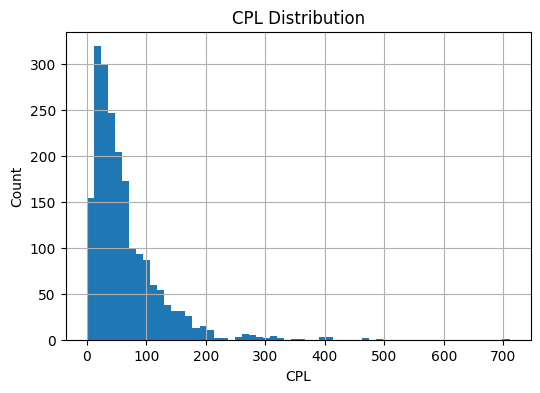

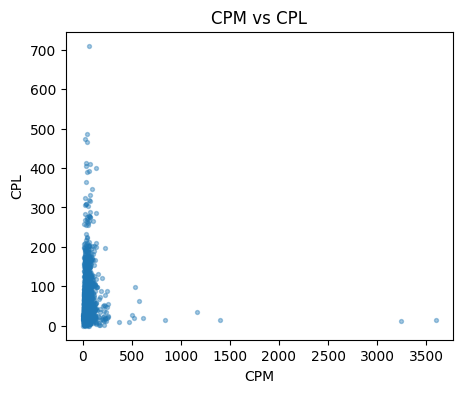

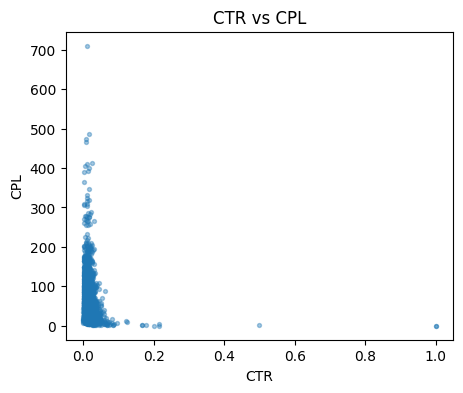

In [21]:
# CPL histogram
if eda_df["CPL"].notna().sum() > 5:
    plt.figure(figsize=(6,4))
    eda_df["CPL"].dropna().hist(bins=60)
    plt.title("CPL Distribution")
    plt.xlabel("CPL"); plt.ylabel("Count")
    plt.show()

# CPM vs CPL (cost pressure vs outcome)
plt.figure(figsize=(5,4))
plt.scatter(eda_df["CPM"], eda_df["CPL"], s=8, alpha=0.4)
plt.title("CPM vs CPL"); plt.xlabel("CPM"); plt.ylabel("CPL")
plt.show()

# CTR vs CPL (engagement vs outcome)
plt.figure(figsize=(5,4))
plt.scatter(eda_df["CTR"], eda_df["CPL"], s=8, alpha=0.4)
plt.title("CTR vs CPL"); plt.xlabel("CTR"); plt.ylabel("CPL")
plt.show()

In [22]:
# CPL segment tables (rank by low median & low std)

def segment_table(df, by, min_n=50):
    cols = by + ["CPL"]
    if not set(cols).issubset(df.columns):
        return None
    t = (df.dropna(subset=["CPL"])
           .groupby(by)["CPL"]
           .agg(count="count", mean="mean", median="median", std="std"))
    t = t.assign(cv = t["std"] / (t["mean"].replace(0, np.nan).abs()))
    t = (t.reset_index()
           .query("count >= @min_n")
           .sort_values(["median","std","count"], ascending=[True,True,False]))
    return t

segment_specs = [
    ["Platform"], ["Device platform"], ["Objective"],
    ["Platform","Device platform"]
]

for spec in segment_specs:
    t = segment_table(eda_df, spec, min_n=50)
    if t is not None and len(t):
        print(f"\nTop segments by {spec} (low median CPL, small dispersion):")
        print(t.head(10))



Top segments by ['Platform'] (low median CPL, small dispersion):
    Platform  count       mean     median        std        cv
1  instagram    701  59.573634  44.560000  52.627946  0.883410
0   facebook   1294  65.126788  47.368333  62.543051  0.960328

Top segments by ['Device platform'] (low median CPL, small dispersion):
  Device platform  count       mean   median        std        cv
1      mobile_app   1942  64.652794  47.7625  59.398013  0.918723

Top segments by ['Objective'] (low median CPL, small dispersion):
       Objective  count      mean     median        std        cv
0  OUTCOME_LEADS   1995  63.17553  46.241664  59.294386  0.938566

Top segments by ['Platform', 'Device platform'] (low median CPL, small dispersion):
    Platform Device platform  count       mean  median        std        cv
3  instagram      mobile_app    701  59.573634   44.56  52.627946  0.883410
1   facebook      mobile_app   1241  67.521844   49.72  62.739853  0.929179


## EDA Summary (CPL Segments)

Dataset: 9,617 rows, CPL present on all rows but with heavy zero-inflation.

Most segments show median CPL = 0, driven by rows with 0 leads or non-lead objectives. Segments that appear “best” (e.g., mobile_web, desktop) are largely zero-only.

Actionable signal lives in mobile_app (majority of delivery), where mean CPL is non-zero but dispersion is high.

Recommendation for baselines/segments:
 - Recompute effective CPL = Amount spent / Leads; set NaN when Leads==0 (do not record 0) -> See below for amount of data left if feasible to utilise
 - Could utilise gates (e.g., Impressions ≥ 100 and Amount spent ≥ 5) to avoid no-delivery rows.
 - Rank segments by median effective CPL, with dispersion (IQR/std) and measurable coverage (share of rows with Leads>0).
 - Validate stability by month (same ranking holds across time).
 - Things you can utilise if needed: engineered features, leakage-safe feature lists, chronological split policy, and a ready preprocessor (see earlier cells).

In [23]:
df_train = eda_df.copy()

df_train["CPL_eff"] = np.where(
    (pd.to_numeric(df_train.get("Leads", 0), errors="coerce") > 0) &
    (pd.to_numeric(df_train.get("Amount spent", 0), errors="coerce") > 0),
    pd.to_numeric(df_train["Amount spent"], errors="coerce") /
    pd.to_numeric(df_train["Leads"], errors="coerce"),
    np.nan
)

def segment_table(df, by, min_n=50):
    cols = by + ["CPL_eff"]
    if not set(cols).issubset(df.columns):
        return None
    t = (df.dropna(subset=["CPL_eff"])
           .groupby(by)["CPL_eff"]
           .agg(count="count", mean="mean", median="median", std="std"))
    t = t.assign(cv = t["std"] / (t["mean"].replace(0, np.nan).abs()))
    t = (t.reset_index()
           .query("count >= @min_n")
           .sort_values(["median","std","count"], ascending=[True,True,False]))
    return t

for spec in segment_specs:
    t = segment_table(df_train, spec, min_n=50)
    if t is not None and len(t):
        print(f"\nTop segments by {spec} (low median CPL, small dispersion):")
        print(t.head(10))


Top segments by ['Platform'] (low median CPL, small dispersion):
    Platform  count       mean     median        std        cv
1  instagram    701  59.573634  44.560000  52.627946  0.883410
0   facebook   1294  65.126788  47.368333  62.543051  0.960328

Top segments by ['Device platform'] (low median CPL, small dispersion):
  Device platform  count       mean   median        std        cv
1      mobile_app   1942  64.652794  47.7625  59.398013  0.918723

Top segments by ['Objective'] (low median CPL, small dispersion):
       Objective  count      mean     median        std        cv
0  OUTCOME_LEADS   1995  63.17553  46.241664  59.294386  0.938566

Top segments by ['Platform', 'Device platform'] (low median CPL, small dispersion):
    Platform Device platform  count       mean  median        std        cv
3  instagram      mobile_app    701  59.573634   44.56  52.627946  0.883410
1   facebook      mobile_app   1241  67.521844   49.72  62.739853  0.929179


In [24]:
df_train.columns

Index(['Campaign ID', 'Ad set ID', 'Included custom audiences',
       'Excluded custom audiences', 'Custom Audience Defined',
       'Exclusion Defined', 'Ad ID', 'Campaign-Adset-Ad', 'Ads', 'Month',
       'Device platform', 'Platform', 'Currency', 'Amount spent', 'CPM',
       'Reach', 'Impressions', 'Clicks', 'Leads', 'CPL', 'Meta leads',
       'Objective', 'headline', 'Local Language', 'Event', 'Exclusivity',
       'Rental', 'Returns', 'Discounts', 'Frequency', 'Reporting starts',
       'Reporting ends', 'CTR', 'LeadRate', 'SpendPerImpr', 'ConvRate',
       'has_impr', 'has_clicks', 'has_leads', 'month_start', 'month_end',
       'year', 'month', 'quarter', 'month_period', 'headline_len',
       'headline_words', 'headline_has_num', 'CPL_eff'],
      dtype='object')

In [25]:
Features_to_utilise = [
    "Platform","Device platform","Objective",
    "Included custom audiences","Excluded custom audiences",
    "Local Language","Event","Exclusivity","Rental","Returns","Discounts",
    "Frequency","headline_len","headline_words","headline_has_num",
] \
+ [c for c in ["month","year"] if c in fe_platform_df.columns] # for seasonality
# + [col for col in fe_platform_df.columns if col.startswith("hl_embed_")]

# Can consider CTR, SpendPerImpr, CPM
Features_to_utilise
# Obj -> Minimize expected CPL

['Platform',
 'Device platform',
 'Objective',
 'Included custom audiences',
 'Excluded custom audiences',
 'Local Language',
 'Event',
 'Exclusivity',
 'Rental',
 'Returns',
 'Discounts',
 'Frequency',
 'headline_len',
 'headline_words',
 'headline_has_num',
 'month',
 'year']

In [26]:
for c in [
    "Platform","Device platform","Objective",
    "Local Language","Event","Exclusivity","Rental","Returns","Discounts",
    "Frequency","headline_len","headline_words","headline_has_num",
] :
  print("/////////////////")
  print(f'NaN Count: {df_train[c].isna().sum()}')
  display(df_train[c].value_counts())


/////////////////
NaN Count: 0


,count
Platform,
facebook,1294
instagram,701


/////////////////
NaN Count: 0


,count
Device platform,
mobile_app,1942
desktop,40
mobile_web,13


/////////////////
NaN Count: 0


,count
Objective,
OUTCOME_LEADS,1995


/////////////////
NaN Count: 0


,count
Local Language,
nan,1877
1.0,94
0.0,24


/////////////////
NaN Count: 0


,count
Event,
1.0,1538
nan,433
0.0,24


/////////////////
NaN Count: 1391


,count
Exclusivity,
1.0,580
0.0,24


/////////////////
NaN Count: 1892


,count
Rental,
1.0,79
0.0,24


/////////////////
NaN Count: 1888


,count
Returns,
1.0,83
0.0,24


/////////////////
NaN Count: 1948


,count
Discounts,
0.0,24
1.0,23


/////////////////
NaN Count: 0


,count
Frequency,
1.000000,6
1.500000,4
1.250000,3
1.100000,3
1.183673,3
...,...
1.503561,1
1.301335,1
1.851027,1


/////////////////
NaN Count: 0


,count
headline_len,
44,181
51,106
53,100
43,92
54,87
...,...
92,1
57,1
13,1


/////////////////
NaN Count: 0


,count
headline_words,
8,335
11,262
9,248
6,244
7,196
10,160
12,123
5,94
1,71


/////////////////
NaN Count: 0


,count
headline_has_num,
1,1241
0,754


# Logistic Regression baseline

In [27]:
clf_df = fe_platform_df.copy()

# Drop rows without CPL
clf_df = clf_df[clf_df["CPL"].notna()].copy()
clf_df["CPL"] = pd.to_numeric(clf_df["CPL"], errors="coerce")

In [28]:
# CPL threshold tau so that we have enough positives
# Only positive CPLs to avoid degenerate "all-zero" threshold
cpl_all = clf_df["CPL"]
base = cpl_all[cpl_all > 0]

In [29]:
min_label_count = globals().get("min_label_count", 50)

tau = None
y_low = None
for q in [0.25, 0.30, 0.40, 0.50]:
    t = float(base.quantile(q))
    y = (cpl_all <= t).astype(int)
    # ensure both classes have enough support
    if (y.sum() >= min_label_count) and ((len(y) - y.sum()) >= min_label_count):
        tau = t
        y_low = y
        break

print(f"Selected threshold: {tau}")

Selected threshold: 24.7765625


In [30]:
clf_df["y_low_cpl"] = y_low

print(f"Chosen CPL threshold tau = {tau:.2f}")
print("Class balance (0 = not low CPL, 1 = low CPL):")
print(clf_df["y_low_cpl"].value_counts())

Chosen CPL threshold tau = 24.78
Class balance (0 = not low CPL, 1 = low CPL):
y_low_cpl
0    1496
1     499
Name: count, dtype: int64


In [31]:
# Time-based split using month_period
clf_df = clf_df.sort_values("month_start")
periods = clf_df["month_period"].dropna().unique()
periods.unique()

<PeriodArray>
['2023-03', '2023-04', '2023-05', '2023-06', '2023-07', '2023-08', '2023-09',
 '2023-10', '2023-11', '2023-12', '2024-01', '2024-02', '2024-03', '2024-04',
 '2024-05', '2024-06', '2024-07', '2024-08', '2024-09', '2024-10', '2024-11',
 '2024-12', '2025-01', '2025-02', '2025-03']
Length: 25, dtype: period[M]

In [33]:
periods = sorted(periods)
n_periods = len(periods)
train_cut = int(round(0.6 * n_periods))
val_cut   = int(round(0.8 * n_periods))

train_periods = periods[:train_cut]
val_periods   = periods[train_cut:val_cut]
test_periods  = periods[val_cut:]

train_mask = clf_df["month_period"].isin(train_periods)
val_mask   = clf_df["month_period"].isin(val_periods)
test_mask  = clf_df["month_period"].isin(test_periods)

train_df = clf_df[train_mask]
val_df   = clf_df[val_mask]
test_df  = clf_df[test_mask]

print("Split sizes (train / val / test):",
      len(train_df),",", len(val_df),",", len(test_df))

Split sizes (train / val / test): 939 , 575 , 481


In [35]:
# Feature Sets
cat_cols = [
    c for c in ["Platform", "Device platform", "Objective", "Event", "Local Language"]
    if c in clf_df.columns
]

num_cols = [
    c for c in [
        "Impressions","Reach","Clicks","Leads","Frequency",
        "Amount spent","CTR","LeadRate","SpendPerImpr","ConvRate",
        "headline_len","headline_words","headline_has_num",
        "year","month","quarter"
    ]
    if c in clf_df.columns
]

# To include the embedded columns
# embed_cols = [c for c in clf_df.columns if c.startswith("hl_embed_")]
# num_cols += embed_cols

In [36]:
feature_cols = list(dict.fromkeys(cat_cols + num_cols))  # dedupe while preserving order

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", Pipeline(steps=[
            ("impute", SimpleImputer(strategy="median")),
            ("scale", StandardScaler()),
        ]), num_cols),
    ],
    remainder="drop",
)

# Build X, y for each split
X_train = train_df[feature_cols]
X_val   = val_df[feature_cols]
X_test  = test_df[feature_cols]

y_train = train_df["y_low_cpl"]
y_val   = val_df["y_low_cpl"]
y_test  = test_df["y_low_cpl"]

cpl_train = train_df["CPL"]
cpl_val   = val_df["CPL"]
cpl_test  = test_df["CPL"]

seed = globals().get("seed", 777)

In [39]:
def cpl_at_top_frac(y_true, proba, cpl, frac=0.2):
    """Mean CPL among top frac% most confident 'low CPL' predictions."""
    df_eval = pd.DataFrame({"y": y_true, "proba": proba, "CPL": cpl})
    df_eval = df_eval.dropna(subset=["CPL"])
    n = len(df_eval)
    if n == 0:
        return {
            "top_frac": frac,
            "mean_cpl_top": np.nan,
            "mean_cpl_all": np.nan,
            "reduction_pct": np.nan,
        }
    k = max(1, int(round(frac * n)))
    df_eval = df_eval.sort_values("proba", ascending=False)
    top = df_eval.head(k)
    mean_top = float(top["CPL"].mean())
    mean_all = float(df_eval["CPL"].mean())
    reduction = np.nan
    if mean_all > 0:
        reduction = 100.0 * (1.0 - mean_top / mean_all)
    return {
        "top_frac": frac,
        "mean_cpl_top": mean_top,
        "mean_cpl_all": mean_all,
        "reduction_pct": reduction,
    }

def evaluate_model(model, X, y, cpl, label=""):
    proba = model.predict_proba(X)[:, 1]
    ap = average_precision_score(y, proba)
    try:
        roc = roc_auc_score(y, proba)
    except ValueError:
        roc = np.nan  # e.g., if only one class present
    cpl_stats = cpl_at_top_frac(y, proba, cpl, frac=0.2)
    print(
        f"{label}: AP={ap:.3f}, ROC-AUC={roc if not np.isnan(roc) else float('nan'):.3f}, "
        f"Top {int(cpl_stats['top_frac']*100)}% mean CPL={cpl_stats['mean_cpl_top']:.2f} "
        f"vs overall {cpl_stats['mean_cpl_all']:.2f} "
        f"(reduction={cpl_stats['reduction_pct']:.1f}%)"
    )
    return {"ap": ap, "roc_auc": roc, **cpl_stats}

In [37]:
C_grid = [0.01, 0.1, 1.0, 10.0]
val_scores = []
best_model = None
best_ap = -np.inf

for C in C_grid:
    logreg_pipe = Pipeline(steps=[
        ("pre", preprocessor),
        ("logreg", LogisticRegression(
            C=C,
            max_iter=1000,
            class_weight="balanced",
            random_state=seed,
        )),
    ])
    logreg_pipe.fit(X_train, y_train)
    proba_val = logreg_pipe.predict_proba(X_val)[:, 1]
    ap = average_precision_score(y_val, proba_val)
    val_scores.append({"C": C, "AP": ap})
    if ap > best_ap:
        best_ap = ap
        best_model = logreg_pipe

print("Validation AP by C:")
for row in val_scores:
    print(row)

logreg_results_val = evaluate_model(best_model, X_val, y_val, cpl_val, label="LogReg (val)")
logreg_results_test = evaluate_model(best_model, X_test, y_test, cpl_test, label="LogReg (test)")

Validation AP by C:
{'C': 0.01, 'AP': np.float64(0.8727663723910637)}
{'C': 0.1, 'AP': np.float64(0.9346558526025471)}
{'C': 1.0, 'AP': np.float64(0.9798681114367537)}
{'C': 10.0, 'AP': np.float64(0.9967016183860411)}
LogReg (val): AP=0.997, ROC-AUC=0.999, Top 20% mean CPL=14.74 vs overall 66.99 (reduction=78.0%)
LogReg (test): AP=0.998, ROC-AUC=0.998, Top 20% mean CPL=8.05 vs overall 37.04 (reduction=78.3%)


On the test set, the logistic-regression baseline gets an Average Precision = 0.998 and ROC-AUC = 0.998, so it almost perfectly ranks low-CPL campaigns above the rest. If we only take the top 20% of campaigns by model score, their realised CPL drops from about 37.0 to 8.1 (≈78% reduction), which shows that even a simple linear model could dramatically cut spend if we prioritised those campaigns.

However, this should be read as an optimistic upper bound rather than a deployable pre-launch model, because the features include post performance signals such as clicks, leads and CTR that would not be available at decision time.

## Split into Train-Test

In [ ]:
df_train, df_test = train_test_split(fe_platform_df, test_size=0.2, random_state=42, shuffle=True)

# Can swap the train_test_split to utilise the train + test + val set defined earlier

## Benchmark (Non-Graph Based K-means)

### Feel free to comment if below approach is ok or not
### Benchmark Approach:
1. Using the train dataset with CPL, iteratively run K-means from 2 clusters to 10 clusters, and compute their silhouette score.
2. Using the elbow method on the silhouette scores, and visual inspection on the cluster statistics (How nice the CPL is split), select a optimal cluster count.
3. Use a Random Forest classifier on the train dataset (Now without CPL), to predict the cluster it belongs to which is computed in the previous step.
4. Run test set through decision tree to predict the cluster it belongs to. Prediction is correct if the true CPL falls within the CPL range in the cluster.

### Evaluation Metrics:
#### For clustering:
- Silhouette Score (Higher = Better): Measures how similar a data point is to its own cluster (cohesion) compared to other clusters (separation). Takes into account all the columns involved.
- Weighted Avg Intra Cluster CPL Variance (Lower = Better): Weighted sum of variances of CPL of all clusters.

#### For Prediction of CPL:
- Accuracy/F1 (Higher=Better): Measures if a data point is correctly assigned to the correct cluster.
    **Note that the correct cluster for an entry in the test set is computed by computing the closest cluster using the Train Set KMeans Model, since we do not have ground truth cluster.**


Question: Why not just directly predict CPL (e.g. linear regression)? Why go through the trouble to cluster first then predict the cluster which causes a loss in information?
Justification(?): By predicting cluster for a data entry, we directly identify if its gonna be low CPL or not.

In [ ]:
bm_kmeans_features = [
    "Platform","Device platform","Objective",
    # "Included custom audiences","Excluded custom audiences", <= Omitted cuz they're strings
    # "Local Language", "Exclusivity","Rental","Returns","Discounts", # <= Omitted cuz too much nan
    "Event", "Frequency","headline_len","headline_words","headline_has_num", 'CPL'
] \
+ [c for c in ["month","year"] if c in df_train.columns] # for seasonality
# + [c for c in df_train.columns if c.startswith('hl_embed_')] <= Tried this but no improvement

train_bm_kmeans_df = df_train[bm_kmeans_features]
test_bm_kmeans_df = df_test[bm_kmeans_features]
train_bm_kmeans_df.head()

,Platform,Device platform,Objective,Event,Frequency,headline_len,headline_words,headline_has_num,CPL,month,year
1378,instagram,mobile_app,OUTCOME_LEADS,1.0,1.912052,54,9,1,46.580000,8,2024
1827,facebook,mobile_app,OUTCOME_LEADS,1.0,1.347751,50,11,1,68.200000,5,2023
678,facebook,mobile_app,OUTCOME_LEADS,1.0,1.369115,53,10,1,51.544244,1,2024
1083,instagram,mobile_app,OUTCOME_LEADS,1.0,1.433075,55,10,1,118.954836,1,2024
1559,instagram,mobile_app,OUTCOME_LEADS,1.0,1.553903,44,6,0,20.547959,2,2025


In [ ]:
from sklearn import pipeline
from sklearn.base import clone
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, scale
from sklearn.compose import make_column_transformer
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.impute import SimpleImputer

def wavg_intra_cluster_cpl_var_score(cpl_col, cluster):
    '''
    Computes the weight average intra cluster CPL variance score,
    or how tight out the CPL variance is according to the formula: sum_k[ (N_i / N_total) * var(i) ]

    Assuming k clusters,
    N_i: number of data points in cluster i
    N_total: number of data points in total
    var(i): Variance of cluster i
    '''
    df = pd.DataFrame({'CPL': cpl_col, 'cluster': cluster})
    total_counts = df.shape[0]

    grouped_clusters = df.groupby('cluster')['CPL']
    cluster_variances = grouped_clusters.var()
    cluster_counts = grouped_clusters.count()

    metric = ((cluster_counts / total_counts) * cluster_variances).sum()
    return metric


def compute_cluster_CPL_stats(cpl_col, cluster):
  '''
  Computes statistics of CPL in a cluster (Mean, median, std)

  cpl_col: A series constaining the CPL.
  cluster: A numpy list indiciating which cluster a element in the series belongs.

  Return a tuple containing a dataframe containing summary statistics of each cluster, and also the weighted average CPL variance score.
  '''
  df = pd.DataFrame({'CPL': cpl_col, 'cluster': cluster})
  cluster_stats = (df.groupby('cluster')['CPL'].describe().sort_values('mean'))
  wvag_cpl_var = wavg_intra_cluster_cpl_var_score(cpl_col, cluster)

  return cluster_stats, wvag_cpl_var



bm_kmeans_preprocessor = lambda cpl_weight: make_column_transformer(
    (SimpleImputer(missing_values=np.nan, strategy='median'), ['Event']),
    (OneHotEncoder(handle_unknown='ignore'), ['Platform', 'Device platform', 'Objective']),
    (StandardScaler(), ['Frequency', 'headline_len', 'headline_words', 'headline_has_num', 'CPL', 'month', 'year']),
    (FunctionTransformer(lambda x: x * cpl_weight), ['CPL']), # Multiply weight after standardizing
    remainder='passthrough',
)

bm_kmeans_pipe = lambda n_clusters, cpl_weight: make_pipeline(
    bm_kmeans_preprocessor(cpl_weight),
    MiniBatchKMeans(n_clusters=n_clusters, random_state=0, n_init="auto")
)

For n_cluster=2, silhouette_score=0.6627, wavg_CPL_score=1449.9750, 
cluster_cpl_stats:
          count    mean    std    min     25%     50%     75%     max
cluster                                                              
1        1235.0   38.79  22.15   0.16   20.74   35.19   55.40   88.51
0         361.0  146.92  68.79  89.08  104.71  126.90  164.13  710.17

For n_cluster=3, silhouette_score=0.6457, wavg_CPL_score=762.7603, 
cluster_cpl_stats:
          count    mean    std     min     25%     50%     75%     max
cluster                                                               
1        1153.0   35.67  19.44    0.16   19.89   33.57   51.51   76.73
0         411.0  120.45  33.97   76.89   93.38  111.20  140.51  213.05
2          32.0  322.28  98.03  216.78  268.18  286.90  351.62  710.17

For n_cluster=4, silhouette_score=0.5833, wavg_CPL_score=458.8425, 
cluster_cpl_stats:
         count    mean    std     min     25%     50%     75%     max
cluster                        

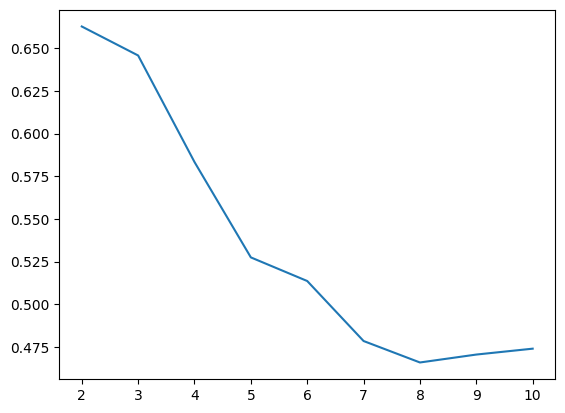

In [ ]:
def run_bm_kmeans(df, n_cluster, cpl_weight=1):
    '''
    Runs 1 kmeans iteration, with all the preprocessing and stuff, to create n_clusters.
    This method runs the kmeans pipeline.

    cpl_weight: How much to scale it, aka give it more importance.
    '''
    pipe = bm_kmeans_pipe(n_cluster, cpl_weight)

    bm_kmeans_model = clone(pipe).fit(df)
    bm_kmeans_pred = bm_kmeans_model.predict(df)
    bm_kmeans_ss = silhouette_score(clone(bm_kmeans_preprocessor(cpl_weight)).fit_transform(df), bm_kmeans_pred)

    return bm_kmeans_model, bm_kmeans_pred, bm_kmeans_ss

def iterate_bm_kmeans(df_train, cpl_weight=1, min_clusters=2, max_clusters=10):
  '''
  Iterates thru some kmeans from min_clusters and max_clusters, and print out their silhouette scores and cluster statistics.
  '''
  df_train = df_train.copy()

  silhouette_scores = []
  for n_cluster in range(min_clusters, max_clusters+1):
    _, bm_kmeans_pred, bm_kmeans_ss = run_bm_kmeans(df_train, n_cluster, cpl_weight)
    cluster_cpl_stats, wvag_cpl_var = compute_cluster_CPL_stats(df_train['CPL'], bm_kmeans_pred)

    with pd.option_context('display.precision', 2):
      print(f'For n_cluster={n_cluster}, silhouette_score={bm_kmeans_ss:.4f}, wavg_CPL_score={wvag_cpl_var:.4f}, \ncluster_cpl_stats:\n{cluster_cpl_stats}\n')

    silhouette_scores.append(bm_kmeans_ss)
  plt.plot(range(min_clusters, max_clusters+1), silhouette_scores)
  plt.show()

bm_kmeans_cpl_weight = 1
iterate_bm_kmeans(train_bm_kmeans_df, cpl_weight=bm_kmeans_cpl_weight) # Seems like cpl_weight = 1 works well already

In [ ]:
train_bm_kmeans_df.head()

,Platform,Device platform,Objective,Event,Frequency,headline_len,headline_words,headline_has_num,CPL,month,year
1378,instagram,mobile_app,OUTCOME_LEADS,1.0,1.912052,54,9,1,46.580000,8,2024
1827,facebook,mobile_app,OUTCOME_LEADS,1.0,1.347751,50,11,1,68.200000,5,2023
678,facebook,mobile_app,OUTCOME_LEADS,1.0,1.369115,53,10,1,51.544244,1,2024
1083,instagram,mobile_app,OUTCOME_LEADS,1.0,1.433075,55,10,1,118.954836,1,2024
1559,instagram,mobile_app,OUTCOME_LEADS,1.0,1.553903,44,6,0,20.547959,2,2025


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score, f1_score, adjusted_rand_score

bm_rand_forest_preprocessor = make_column_transformer(
    (OrdinalEncoder(), ['Platform', 'Device platform', 'Objective']),
    remainder='passthrough',
)

bm_rand_forest_pipe = make_pipeline(
    bm_rand_forest_preprocessor,
    RandomForestClassifier(random_state=seed)
)

# We pick n_clusters = 7 using elbow method.
chosen_n_clusters = 7
bm_kmeans_model_train, bm_kmeans_clusters_train, bm_kmeans_ss_train = run_bm_kmeans(train_bm_kmeans_df, chosen_n_clusters, cpl_weight=bm_kmeans_cpl_weight)
cluster_cpl_stats, wvag_cpl_var = compute_cluster_CPL_stats(train_bm_kmeans_df['CPL'], bm_kmeans_clusters_train)
with pd.option_context('display.precision', 2):
      print(f'For n_cluster={chosen_n_clusters}, silhouette_score={bm_kmeans_ss_train:.4f}, wavg_CPL_score={wvag_cpl_var:.4f}, \ncluster_cpl_stats:\n{cluster_cpl_stats}\n')

bm_kmeans_clusters_test = bm_kmeans_model_train.predict(test_bm_kmeans_df)

bm_rand_forest = clone(bm_rand_forest_pipe).fit(train_bm_kmeans_df, bm_kmeans_clusters_train)
bm_rand_forest_pred_train = bm_rand_forest.predict(train_bm_kmeans_df)
bm_rand_forest_pred_test = bm_rand_forest.predict(test_bm_kmeans_df)

wavg_intra_cluster_cpl_var_score(train_bm_kmeans_df['CPL'], bm_kmeans_clusters_train)

print(
    f'Train Value Counts for Each Cluster: {np.unique_counts(bm_kmeans_clusters_train).counts}',
    f'\n'
    f'Test Value Counts for Each Cluster: {np.unique_counts(bm_kmeans_clusters_test).counts}'
)

print(
    f'TRAIN Accuracy: {accuracy_score(bm_kmeans_clusters_train, bm_rand_forest_pred_train):.4f}',
    f'TEST Accuracy: {accuracy_score(bm_kmeans_clusters_test, bm_rand_forest_pred_test):.4f}',
    f'\n'
    f'TRAIN F1: {f1_score(bm_kmeans_clusters_train, bm_rand_forest_pred_train, average="weighted"):.4f}',
    f'TEST F1: {f1_score(bm_kmeans_clusters_test, bm_rand_forest_pred_test, average="weighted"):.4f}',
)


For n_cluster=7, silhouette_score=0.4785, wavg_CPL_score=245.8363, 
cluster_cpl_stats:
         count    mean    std     min     25%     50%     75%     max
cluster                                                              
4        354.0   13.98   5.88    0.16    9.11   14.87   19.01   22.45
6        387.0   31.97   5.70   22.47   26.93   31.87   36.52   42.37
1        345.0   55.00   7.62   42.35   48.88   54.59   61.74   68.59
0        236.0   85.01  10.72   68.67   75.38   83.87   94.78  103.72
5        164.0  124.64  13.61  104.07  112.70  124.41  134.20  152.00
3         84.0  181.51  21.92  153.27  164.44  174.63  195.15  256.64
2         26.0  342.45  97.98  266.27  277.33  308.80  384.38  710.17

Train Value Counts for Each Cluster: [236 345  26  84 354 164 387] 
Test Value Counts for Each Cluster: [ 62  95   9  20  81  29 103]
TRAIN Accuracy: 1.0000 TEST Accuracy: 0.9749 
TRAIN F1: 1.0000 TEST F1: 0.9737
